# White noise analysis for Mi1 or L2

In [125]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.backends.backend_pdf as plt2
import seaborn as sb
sb.set_color_codes()
sb.set_palette("Reds")
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.cm as mcm
import matplotlib.colors as mcolors


## Select the cell type

In [15]:
celltype = 'Mi1' # 'L2'

In [16]:
# load receptive fields for all cells 
RFs = np.load('Data\\centeredRFs_' + celltype + '.npy')
# load receptive field summary data 
df = pd.read_pickle('Data\\RFdata_' + celltype + '.pkl')

In [17]:
df

,zscore,maxima_i [px],maxima_j [px],maxima_t [px],centers_i_fitted [px],centers_j_fitted [px],sigma_i [px],sigma_j [px],flyID,centers_i_fitted [deg],centers_j_fitted [deg],sigma_i [deg],sigma_j [deg]
0,11.201789,32.0,35.0,111.0,31.864771,35.449809,0.950430,0.267463,0,88.974081,1.770835,2.673083,0.737133
1,10.286579,33.0,38.0,109.0,32.834516,38.402956,0.873468,0.975798,0,86.246675,9.820879,2.456627,2.613191
2,11.954259,33.0,34.0,112.0,32.988345,33.706454,0.848387,0.782538,0,85.814031,-3.035128,2.386089,2.152474
3,13.280006,34.0,37.0,108.0,33.731650,36.759566,0.823495,0.828264,0,83.723485,5.368838,2.316080,2.264629
4,14.169899,32.0,32.0,111.0,32.118350,32.401598,0.696470,0.632974,0,88.260889,-6.608200,1.958823,1.722926
5,13.893601,33.0,35.0,110.0,33.377354,35.293201,0.711464,0.607078,0,84.719943,1.339122,2.000992,1.673705
6,14.699949,33.0,31.0,108.0,32.914111,30.857157,0.690383,0.697491,0,86.022812,-10.769633,1.941702,1.856827
7,13.209827,34.0,34.0,112.0,34.389447,33.663936,0.787100,0.691462,0,81.873430,-3.152079,2.213720,1.901586
8,11.079813,32.0,30.0,111.0,32.291974,29.533349,0.880684,0.774677,0,87.772574,-14.249042,2.476922,2.007452
9,13.842032,34.0,32.0,111.0,33.651985,32.275828,0.816127,0.741819,0,83.947542,-6.950324,2.295357,2.016280


In [18]:
# RF width in azimuth
print df['sigma_i [deg]'].mean(), 'Sigma'
print df['sigma_i [deg]'].std(), '+=STD'
print df['sigma_i [deg]'].mean()*2.355, 'FWHM'
print df['sigma_i [deg]'].std()*2.355, '+-STD'

2.36811103896 Sigma
0.370198573293 +=STD
5.57690149675 FWHM
0.871817640104 +-STD


In [19]:
# RF width in elevation
print df['sigma_j [deg]'].mean(), 'Sigma'
print df['sigma_j [deg]'].std(), '+=STD'
print df['sigma_j [deg]'].mean()*2.355, 'FWHM'
print df['sigma_j [deg]'].std()*2.355, '+-STD'

2.02486818606 Sigma
0.296521639828 +=STD
4.76856457818 FWHM
0.698308461796 +-STD


In [85]:
time = np.arange(-2,0.5,1/60.) #time axis in seconds
extend = 5*180/64. # average size of 5 px in deg 

In [127]:
# in RFs the dimensions are as follows:
# 0 .... x / phi / azimuth
# 1 .... y / z / elevation
# 2 .... ROIs / cells
# 3 ... time axis 

# to plot a 2D spatial RF with the x axis to be phi, and the y axis to have 0 at the bottom, you have to:
# transpose
# flip the y axis

# get the mean RF
meanallROIs = np.mean(RFs, axis = 2)
stdallROIs = np.std(RFs, axis = 2)

In [128]:
# get the value and indices of the RF maximum 
if celltype == 'L2':
    maxidx = np.unravel_index(np.argmin(meanallROIs), meanallROIs.shape)
elif celltype == 'Mi1':
    maxidx = np.unravel_index(np.argmax(meanallROIs), meanallROIs.shape)

maxidx_value = meanallROIs[maxidx]

In [129]:
print maxidx_value
print maxidx

0.8991262125314226
(5, 5, 112)


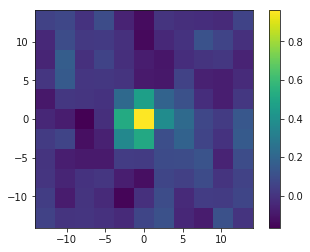

In [41]:
# spatial receptive field of example cell
exampleROI = 53
plt.imshow(np.transpose(RFs[::-1,:,exampleROI,maxidx[2]]), extent = (-extend,extend,extend,-extend))
plt.colorbar()
plt.gca().invert_yaxis()

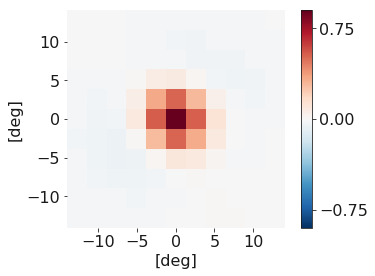

In [58]:
# spatial receptive field, average of all cells

fig1 = plt.figure()
ax = plt.subplot(111)
if celltype == 'L2':
    plt.imshow(np.transpose(meanallROIs[::-1,:,maxidx[2]]), vmin = maxidx_value, vmax = np.abs(maxidx_value), extent=(-extend,extend,extend,-extend), cmap = 'RdBu_r')
elif celltype == 'Mi1':
    plt.imshow(np.transpose(meanallROIs[::-1,:,maxidx[2]]), vmin = -maxidx_value, vmax = maxidx_value, extent=(-extend,extend,extend,-extend), cmap = 'RdBu_r')

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('[deg]', fontsize = 16)
plt.box([])
plt.ylabel('[deg]', fontsize = 16)
plt.gca().invert_yaxis()
cb = plt.colorbar()
cb.set_ticks([-0.75,0,0.75])
cb.ax.tick_params(labelsize=16)


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 7 Text yticklabel objects>)

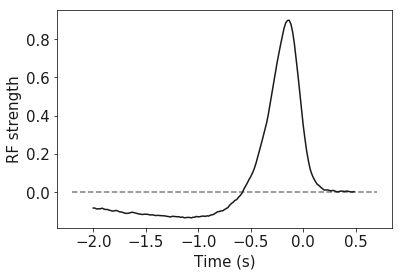

In [59]:
#1D temporal RF, average of all cells
plt.plot(time, meanallROIs[maxidx[0], maxidx[1], :], 'k')
plt.hlines(0,-2.2,0.7, linestyle = '--', color = [0.5,0.5,0.5])
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('RF strength', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

<Figure size 432x288 with 0 Axes>

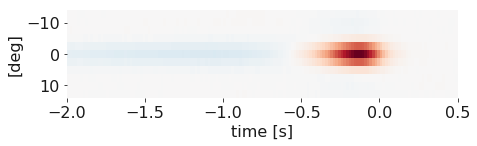

In [44]:
#2D temporal receptive field, average of all cells

fig2 = plt.figure()
plt.figure(figsize = (7,7))
ax = plt.subplot(111)
if celltype == 'L2':
    plt.imshow(meanallROIs[:,maxidx[1],:], vmin = maxidx_value, vmax = np.abs(maxidx_value), extent = [-2,0.5,-extend,extend],  cmap = 'RdBu_r')
elif celltype == 'Mi1':
    plt.imshow(meanallROIs[:,maxidx[1],:], vmin = -maxidx_value, vmax = maxidx_value, extent = [-2,0.5,-extend,extend],  cmap = 'RdBu_r')

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('time [s]', fontsize = 16)
plt.box([])
plt.ylabel('[deg]', fontsize = 16)
plt.gca().invert_yaxis()
ax.set_aspect(0.02)

### Receptive field strength around the circumfence and diagonals

In [62]:
N_pixels = 5  # middle pixel

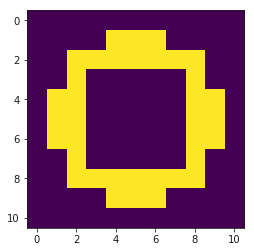

In [64]:
# make the mask for the circumfence RF
x =  np.arange(meanallROIs.shape[0]) - N_pixels
y =  np.arange(meanallROIs.shape[1]) - N_pixels
xx, yy = np.meshgrid(x,y)
i = 17
lower = 9
upper = 18
mask = ((xx**2 + yy**2)>=lower)&((xx**2 + yy**2)<=upper)
plt.imshow(mask)

In [89]:
def cart2pol(x, y):
    """ takes cartesian coordinates and returns polar """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [90]:
# convert the meshgrid locations of the circumfence to polar
rho, phi = cart2pol(xx[mask], yy[mask])
print phi

[-1.81577499 -1.57079633 -1.32581766 -2.35619449 -2.15879893 -1.89254688
 -1.57079633 -1.24904577 -0.98279372 -0.78539816 -2.55359005 -0.5880026
 -2.89661399 -2.8198421  -0.32175055 -0.24497866  3.14159265  3.14159265
  0.          0.          2.89661399  2.8198421   0.32175055  0.24497866
  2.55359005  0.5880026   2.35619449  2.15879893  1.89254688  1.57079633
  1.24904577  0.98279372  0.78539816  1.81577499  1.57079633  1.32581766]


In [91]:
# get all the data along the circumfence (masked meanallROIs)
data = np.transpose(np.mean(meanallROIs[::-1,:,maxidx[2]-5:maxidx[2]+5], axis = 2))[mask]

Text(0,0.5,'RF strength')

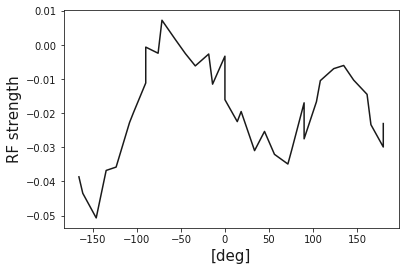

In [92]:
# plot RF along circumfence 
plt.plot(phi[np.argsort(phi)]*180./np.pi, data[np.argsort(phi)], linestyle = '-', color = 'k')
plt.xlabel('[deg]', fontsize = 15)
plt.ylabel('RF strength', fontsize = 15)

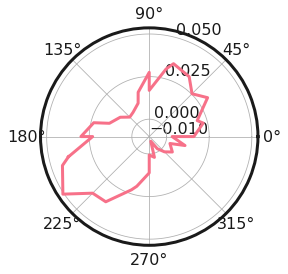

In [93]:
# RF strength along cirumfence in polar coordinates
figx1 = plt.figure()
mypalette = sb.husl_palette(3)
ax = plt.subplot(111, projection='polar')
phisorted = np.concatenate((phi[np.argsort(phi)], [phi[np.argsort(phi)][0]]))
datasorted = np.concatenate((data[np.argsort(phi)], [data[np.argsort(phi)][0]]))
ax.plot(phisorted, -datasorted, color = mypalette[0], linewidth = 3)
ax.set_rticks([-0.01, 0, 0.025, 0.05])  # less radial ticks
ax.set_rlabel_position(75)
ax.tick_params(labelsize = 16)
ax.spines['polar'].set_linewidth(3)


In [100]:
# get RF strength along diagonals
d1 = []
d2 = []
c = 0
dpxls = np.zeros((11,11))
dtime = np.zeros((meanallROIs.shape[0], meanallROIs.shape[2]))
for i in np.arange(meanallROIs.shape[0]):
    d1.append(meanallROIs[-i-1,i,maxidx[2]])
    d2.append(meanallROIs[10-i,10-i,maxidx[2]])
    dtime[c,:] = meanallROIs[-i,i,:]
    dpxls[10-i,10-i] = 1
    c +=1

In [101]:
xdata = np.linspace(-extend, extend, meanallROIs.shape[0])
ydata = -meanallROIs[maxidx[0],:,maxidx[2]]

Text(0.5,0,'[$^\\circ$]')

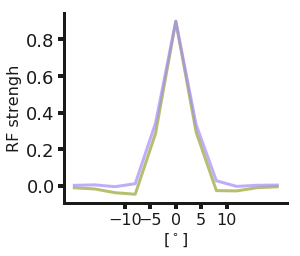

In [102]:
figx8 = plt.figure(figsize = (4,3.5))
mypalette = sb.husl_palette(4)
ax = plt.subplot(111)
plt.plot(xdata*np.sqrt(2),np.array(d1), color = mypalette[1], linewidth = 3,alpha = 0.7)
plt.plot(xdata*np.sqrt(2),np.array(d2), color = mypalette[3], linewidth = 3,alpha = 0.7)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.tick_params(length = 6, width = 4)        
plt.yticks(fontsize = 18)
plt.xticks(np.arange(-10,11,5),fontsize = 16)
plt.ylabel('RF strengh', fontsize = 16)
plt.xlabel('[$^\circ$]', fontsize = 16)

### Surround RF strength relative to center

3.7965228676400633
5.025821850228457
-1.2292989825883933


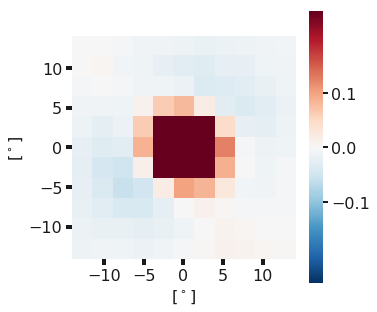

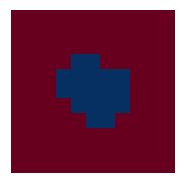

In [126]:

figx2 = plt.figure(figsize = (5,5))
ax2 = plt.subplot(111)

if celltype == 'L2':
    plt.imshow(np.transpose(meanallROIs[::-1,:,maxidx[2]]), vmin = maxidx_value+0.6, vmax = np.abs(maxidx_value)-0.6, extent=(-extend,extend,extend,-extend), cmap = cmap)

elif celltype == 'Mi1':
    plt.imshow(np.transpose(meanallROIs[::-1,:,maxidx[2]]), vmin = -maxidx_value+0.65, vmax = np.abs(maxidx_value)-0.65, extent=(-extend,extend,extend,-extend), cmap = cmap)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('[$^\circ$]', fontsize = 16)
plt.box([])

ax2.tick_params(length = 6, width = 4)        

plt.ylabel('[$^\circ$]', fontsize = 16)
plt.gca().invert_yaxis()
cb = plt.colorbar()
cb.set_ticks([-0.1,0,0.1])
cb.ax.tick_params(labelsize=16)
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=16, length = 5, width = 2) 

figx3 = plt.figure(figsize = (3,3))
if celltype == 'L2':
    masks = (np.transpose(meanallROIs[::-1,:,maxidx[2]])> -0.03)
    maskc = (np.transpose(meanallROIs[::-1,:,maxidx[2]])<-0.03)
elif celltype == 'Mi1':
    masks = (np.transpose(meanallROIs[::-1,:,maxidx[2]])<0.03)
    maskc = (np.transpose(meanallROIs[::-1,:,maxidx[2]])>0.03)

plt.imshow(masks.astype(float), cmap = 'RdBu_r')
#plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.box([])
plt.gca().invert_yaxis()


data_temp = np.transpose(meanallROIs[::-1,:,maxidx[2]])
print np.sum(data_temp)
print np.sum(data_temp[maskc])
print np.sum(data_temp[masks])



In [120]:
def mean_confidence_interval2(m, std, n, confidence = 0.95):
    q = confidence + (1-confidence)/2
    z_critical = norm.ppf(q = q)  
    margin_of_error = z_critical * (std/np.sqrt(n))
    return m, m - margin_of_error, m + margin_of_error


In [123]:
cs = []
ss = []
for i in range(RFs.shape[2]):
    
    data1R = np.transpose(RFs[::-1,:,i,maxidx[2]])
    data1R = -data1R 
    cs.append(np.sum(data1R[maskc]))
    data1R = -data1R 
    ss.append(np.sum(data1R[masks]))

foo, lower, upper = mean_confidence_interval2(np.mean(cs), np.std(cs),len(cs))
confics = np.array(upper - lower)/2.

foo, lower, upper = mean_confidence_interval2(np.mean(ss), np.std(ss),len(ss))
confiss = np.array(upper - lower)/2.

(0, 5.2)

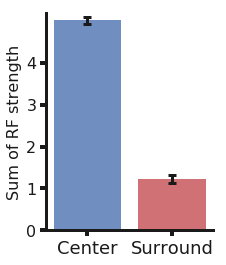

In [122]:
figx7 = plt.figure(figsize = (3,4))
ax = plt.subplot(111)
error_kw = {'elinewidth': 3, 'capsize': 4, 'capthick': 3}   
plt.bar([0,1],[np.abs(np.sum(data_temp[maskc])), np.abs(np.sum(data_temp[masks]))],yerr = [confics, confiss], color = ['b','r'], alpha = 0.8, error_kw = error_kw)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.tick_params(length = 6, width = 4)        
plt.xticks([0,1],['Center', 'Surround'], fontsize = 18)
plt.yticks(fontsize = 16)
plt.ylabel('Sum of RF strength', fontsize = 16)
plt.yticks(np.arange(5))
plt.ylim(0,5.2)